# Assignment 2 - Sample solution

In [28]:
import numpy as np
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import mylib as my

## PART A: Random forests: Out of bag score

Random forests (and bagging methods in general) can be evaluated by calculating the **out-of-bag** score. This score eliminates the need for a separate validation set or cross-validation. To compute it, follow these steps:

* For each example $x$ in the training set, identify the list of trees that were trained using samples that do not include $x$. In the context of these trees, $x$ is considered an unseen example and thus 'out of bag.'
* Apply the predict method to each of these trees to obtain a list of predictions for $x$.
* Determine the final prediction for $x` by selecting the class that appears most frequently among these predictions.

The accuracy of the final predictions for all out-of-bag examples is referred to as the out-of-bag score."

In this section of the assignment, your task is to calculate the out-of-bag score for a given random forest model and then compare it with the score calculated by SciKit Learn. To calculate this score manually, you will require access to the bootstrap samples used for training the random forest trees. However, SciKit Learn doesn't provide direct access to these samples. Instead, you can reconstruct them using the following function, which utilizes the `RandomState` that initially generated them.

In [29]:
import sklearn.ensemble._forest as forest_utils

def get_bootstrap_samples_indices(rf, n_samples):
    n_samples_bootstrap = forest_utils._get_n_samples_bootstrap(
        n_samples, rf.max_samples
    )

    bootstrap_sample_indices_per_tree = []
    for estimator in rf.estimators_:
        sampled_indices = forest_utils._generate_sample_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        bootstrap_sample_indices_per_tree.append(sampled_indices)
        
    return bootstrap_sample_indices_per_tree

Here is the model for which you will calculate the **out-of-bag** score. When setting the parameter `oob_score=True` in SciKit Learn, it instructs the library to compute the out-of-bag score for this model.

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=11)

Let's get started.

* **(5 points)** Load the iris dataset from `sklearn.datasets` and display the shapes of its input and output data.

In [82]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

ds = load_iris()

X = ds.data
y = ds.target

# OOB needs entire dataset.
X.shape, y.shape





((150, 4), (150,))

* **(5 points)** Fit the above random forest model to the entire Iris dataset, and then utilize the `get_bootstrap_samples_indices()` function to regenerate the bootstrap samples used in training this model. Remember that an example is considered out-of-bag for a tree if it was not included in the bootstrap sample on which that tree was trained.

In [83]:
# Fit the forest to the entire dataset
rf.fit(X,y)

#bsi is the boostrap samples indices, returned from the function as a list of arrays.
bsi = get_bootstrap_samples_indices(rf, len(X))

len(bsi)
# rf.fit(X_train,y_train)

50

* **(20 points)** Implement the logic that calculates the out-of-bag score as described above.

In [105]:
from sklearn.metrics import accuracy_score

def calculate_oob_score(rf, bsi):
    
    # Initialize oon tree predictions
    oob_predictions = []

    oob_errors = 0
   
    # Iterate through all samples
    for i in range(len(X)):
        
        # Initialize oob trees
        oob_trees = []
        
        # Iterate through all trees in the Random Forest
        for tree_idx in range(len(rf.estimators_)):
            
            # Check if the data point 'i' is not in the bootstrap sample indices for this tree
            if i not in bsi[tree_idx]:
                
                # If 'i' is not in the bootstrap sample, add this tree's index to the list of oob trees
                oob_trees.append(tree_idx)

        # oob_tree predictions using the missing 'i' are stored
        oob_tree_predictions = [rf.estimators_[tree_idx].predict([X[i]])[0] for tree_idx in oob_trees]

        # Aggregate oob_tree predictions
        if oob_tree_predictions:
            oob_predictions.append(max(set(oob_tree_predictions), key = oob_tree_predictions.count))

        # Compare the prediction to the real output, marking incorrect predictions
        if oob_predictions[-1] != y[i]:
            oob_errors += 1
            
    # Calculate oob score
    oob_score = 1 - (oob_errors / len(X))
    
    return oob_score



In [106]:
my_oob_score = calculate_oob_score(rf,bsi)
my_oob_score

0.96

* **(2 points)** Display your calculated out-of-bag score along with the score calculated by SciKit Learn, which you can access using the learned parameter `oob_score_`.

In [410]:
sk_oob_score = rf.oob_score_
sk_oob_score, my_oob_score

(0.96, 0.96)

## PART B: The effect of weak learners on boosting algorithms

Boosting algorithms such as AdaBoost require the use of **weak learners**. A weak learner is a model that performs slightly better than a random guess. In this section, you will investigate the effect of weak learners on boosting algorithms using the given XOR data below. 

In [440]:
X = np.random.uniform(-1, 1, size=(500, 2))
y = np.ones(len(X))

y[X[:, 0] * X[:, 1]< 0] =  0 

This is simple linearly inseparable data that is known to cause problems for many classifiers. Let's get started:

* **(5 points)** Split this data in an 60/20/20 manner to three sets: training, validation, and testing.

In [441]:
# Split the data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=11)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=11)

X_train.shape, y_train.shape,  X_val.shape, y_val.shape, X_test.shape, y_test.shape

((300, 2), (300,), (120, 2), (120,), (80, 2), (80,))

* **(5 points)** Train a very shallow decision tree  (with `max_depth=1`) on this data and print its training and validation accuracies.

In [413]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(max_depth=1)

dt.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=1)

* **(8 points)** Create and show a figure with two side-by-side plots: one plotting the above tree and another plotting the training data and marking the split line indicated in the tree plot.

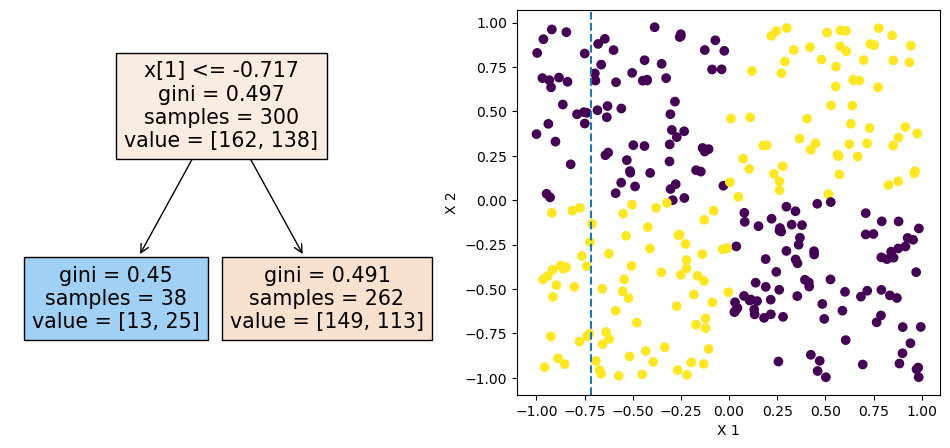

In [414]:

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot the decision tree
plt.subplot(1, 2, 1)
plot_tree(dt, filled=True) 

# Plot the training data with the split line on the right subplot
plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel("X 1")
plt.ylabel("X 2")

# Plot the split line indicated by the decision tree
split_threshold = dt.tree_.threshold[0]  # Get the threshold from the decision tree
plt.axvline(split_threshold, linestyle='--')

# Show the figure
plt.show()


* **(15 points)** Train multiple AdaBoost and Gradient Boosting classifiers with different values the `n_estimators` parameter. Vary the `n_estimators` values using `range(1, 300, 5)`. For every value: 
    * train an AdaBoost model using the previous decision tree as the base estimator.
    * train a gradient boosting model with a `max_depth=1` parameter. 
    
    
  =Store the training and validation accuracies of these models and use them to plot the learning curves: `n_estimators` vs. accuracy. Use a figure with two side-by-side plots: one for AdaBoost's curves and another for Gradient Boosting's curves. Equip these plots with the necessary labels, titles, and legends.

In [418]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

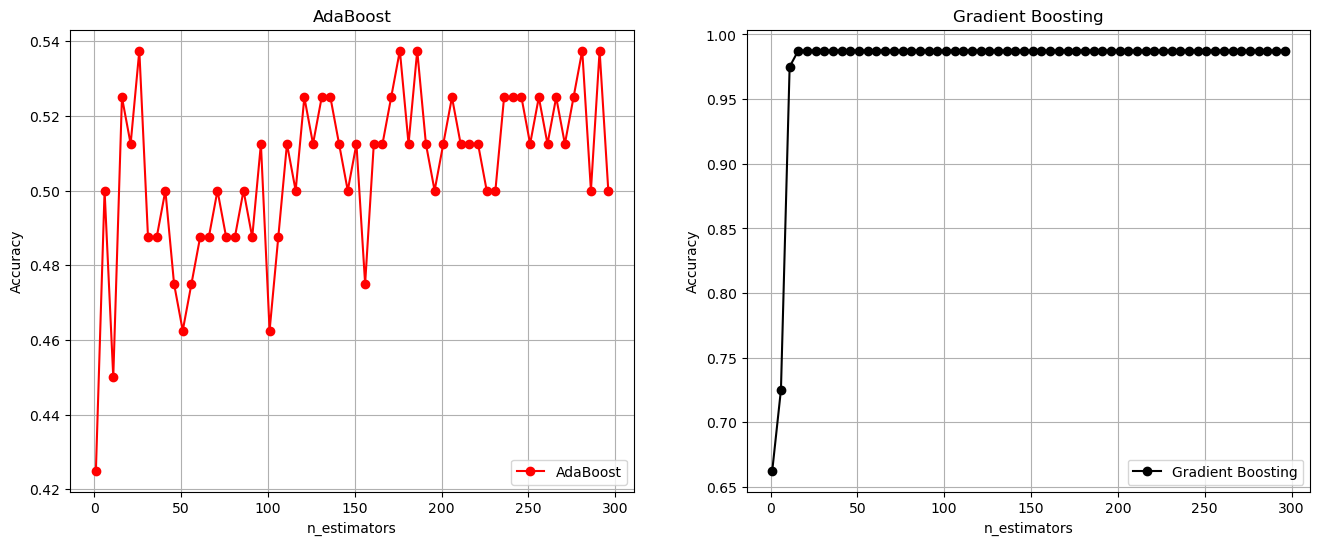

In [419]:
n_estimators_range = range(1, 300, 5)

ada_boost_scores = []

gradient_boost_scores = []

for n_estimators in n_estimators_range:
    # Create and train AdaBoost classifier
    ada_boost_classifier = AdaBoostClassifier(
        estimator=dt,  # Use your custom decision tree here
        n_estimators=n_estimators,
    )
    ada_boost_classifier.fit(X_train, y_train)
    ada_boost_predictions = ada_boost_classifier.predict(X_test)
    ada_boost_accuracy = accuracy_score(y_test, ada_boost_predictions)
    ada_boost_scores.append(ada_boost_accuracy)

    gradient_boost_classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gradient_boost_classifier.fit(X_train, y_train)
    gradient_boost_predictions = gradient_boost_classifier.predict(X_test)
    gradient_boost_accuracy = accuracy_score(y_test, gradient_boost_predictions)
    gradient_boost_scores.append(gradient_boost_accuracy)




plt.figure(figsize=(16, 6))

# Plot AdaBoost results on the left
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, ada_boost_scores, label='AdaBoost', c='r', marker='o')
plt.title('AdaBoost')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Gradient Boosting results on the right
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, gradient_boost_scores, label='Gradient Boosting', c='k', marker='o')
plt.title('Gradient Boosting')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()






* **(5 points)** Let's improve on the previous models by using better weak learners. Train a decision tree with a `max_depth=2`. Plot this tree and print its training and validation accuracies.

(0.6533333333333333, 0.65)

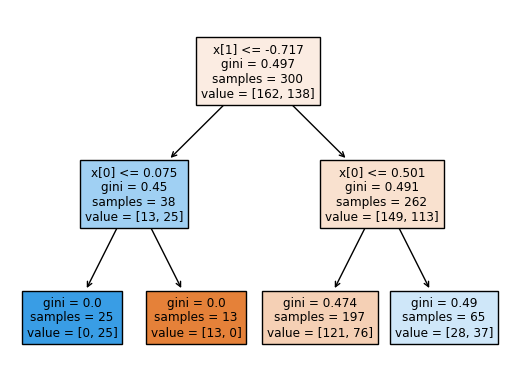

In [420]:
ada_boost_scores = []
gradient_boost_scores = []

dt= DecisionTreeClassifier(max_depth=2)
dt.fit(X_train,y_train)

plot_tree(dt, filled=True)

# Calculate training accuracy  (predicted/actual)
train_predictions = dt.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)

# Calculate validation accuracy  (predicted/actual)
validation_predictions = dt.predict(X_val)
validation_accuracy = accuracy_score(y_val, validation_predictions)

train_accuracy, validation_accuracy



* **(5 points)** Using decision trees with max-depth=2, train multiple AdaBoost and Gradient Boosting classifiers with varying values for `n_estimators` in the same way as before. Plot the learning curves.

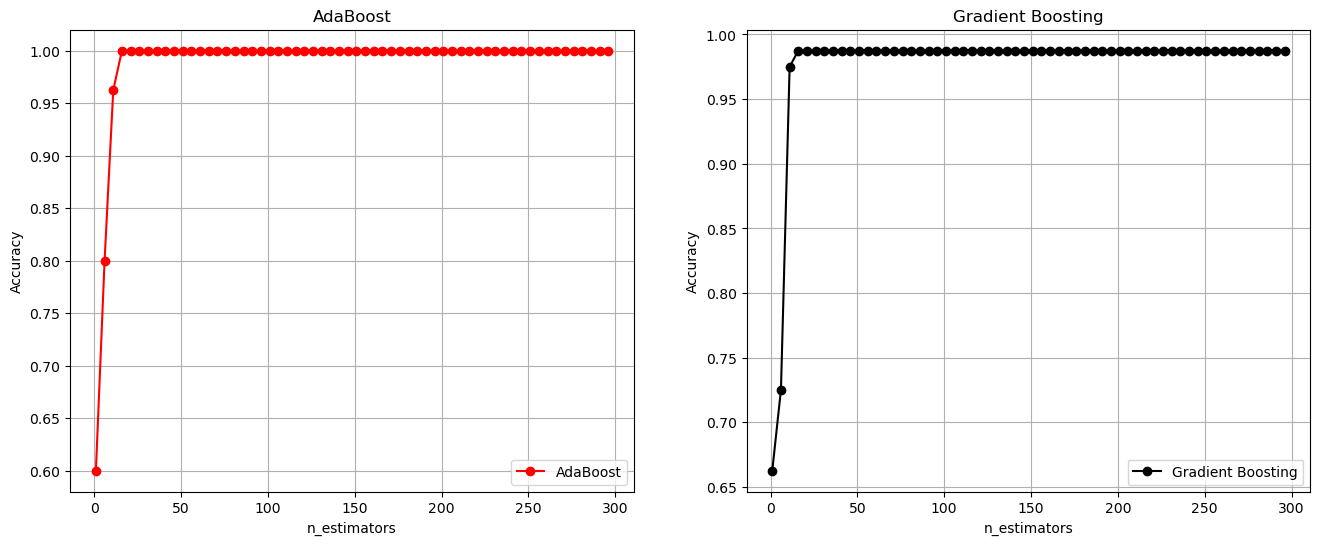

In [421]:
n_estimators_range = range(1, 300, 5)

ada_boost_scores = []

gradient_boost_scores = []

for n_estimators in n_estimators_range:
    # Create and train AdaBoost classifier
    ada_boost_classifier = AdaBoostClassifier(
        estimator=dt,  # Use your custom decision tree here
        n_estimators=n_estimators,
    )
    ada_boost_classifier.fit(X_train, y_train)
    ada_boost_predictions = ada_boost_classifier.predict(X_test)
    ada_boost_accuracy = accuracy_score(y_test, ada_boost_predictions)
    ada_boost_scores.append(ada_boost_accuracy)

    gradient_boost_classifier = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
    gradient_boost_classifier.fit(X_train, y_train)
    gradient_boost_predictions = gradient_boost_classifier.predict(X_test)
    gradient_boost_accuracy = accuracy_score(y_test, gradient_boost_predictions)
    gradient_boost_scores.append(gradient_boost_accuracy)




plt.figure(figsize=(16, 6))

# Plot AdaBoost results on the left
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, ada_boost_scores, label='AdaBoost', c='r', marker='o')
plt.title('AdaBoost')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Gradient Boosting results on the right
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, gradient_boost_scores, label='Gradient Boosting', c='k', marker='o')
plt.title('Gradient Boosting')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()






## PART C: Combating overfitting with early stopping

The last results are much better, but how can we find a good value for the `n_estimator` parameter so that we are not wasting time and resources? In this section, we will implement a technique called early stopping for this purpose. Early stopping gives us another reason to have a validation set. Some models, like gradient boosting and neural networks (as we will see), come with built-in support for it. You  will enable early stopping on gradient boosting models and implement it manually for AdaBoost.

* **(5 points)** First, Train a gradient boosting model with early stopping using a value of 500 for `n_estimators`. Refer to SciKit Learn's documentation page for this model on what parameter(s) to use to enable early-stopping.  Use a tolerance value of 0.0001.

In [ ]:
early_stop = GradientBoostingClassifier(
    n_estimators=500,                   
    tol=0.0001,             # Tolerance Value
    n_iter_no_change=5,     # Number of iterations with no improvement before stopping
    random_state=22
)

early_stop.fit(X_train, y_train)

es_estimators = early_stop.n_estimators_  # early_stop esitmators used

es_estimators




* **(20 points)** Secondly, `AdaBoostClassifier` does come with built-in support for early stopping, so you will implement it. The idea is simple. Inside the loop that iterates over the `n_estimators` values, save the last `n` validation accuracies. Then compare them to one another. If they happen to be within a given tolerance difference from one another, then quit the loop. Otherwise, continue. Use `n = 5` and `tolerance = 0.0001`. Plot the training and validation accuracies just like you did before but stop these curves at the value of `n_estimators` that your code stopped at. Print that value as well.

In [485]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data
X = np.random.uniform(-1, 1, size=(500, 2))
y = np.ones(len(X))
y[X[:, 0] * X[:, 1] < 0] = 0

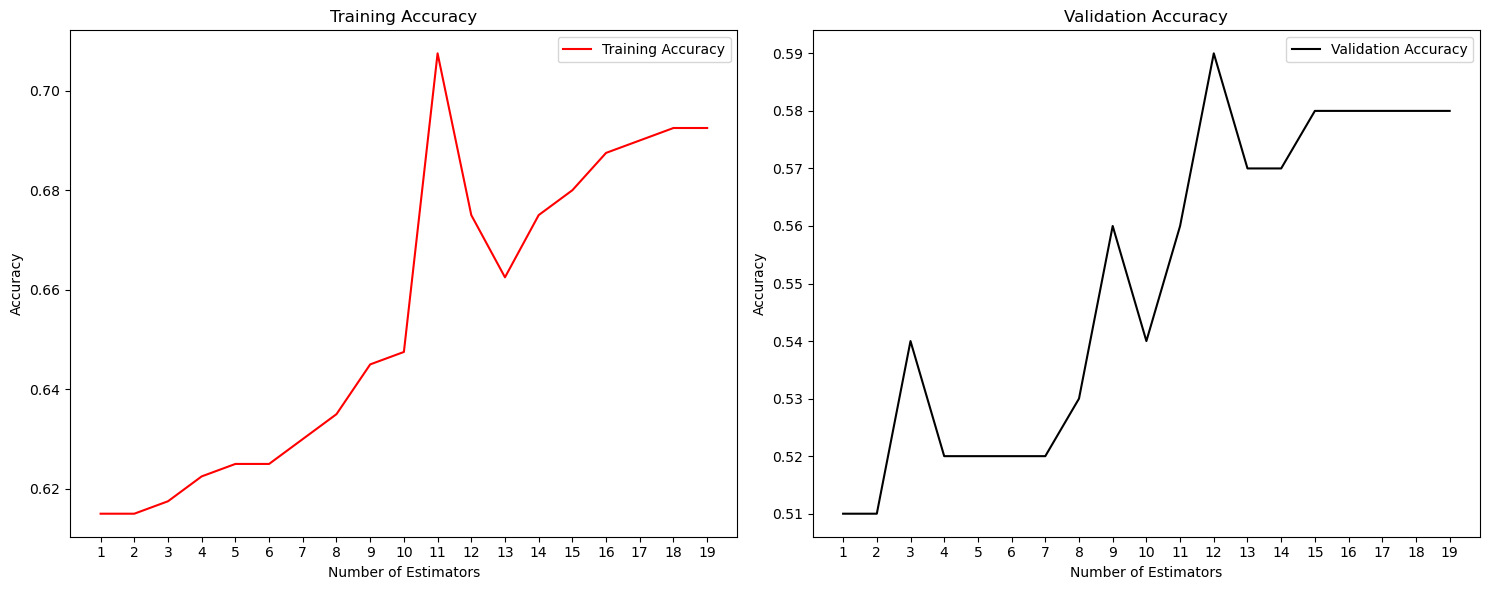

Stopped at n_estimators = 19


In [486]:
# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

# Initialize variables to track accuracies and stopping point

train_accuracies = []
val_accuracies = []
tolerance = 0.0001
n_no_improvement = 5  # Number of consecutive iterations without improvement to trigger early stopping

min_estimators = 5
max_estimators = 500

for e in range(min_estimators, max_estimators + 1):
    ada_classifier = AdaBoostClassifier(n_estimators=e, random_state=19)
    ada_classifier.fit(X_train, y_train)  # Fit the classifier

    # Training accuracy
    y_train_pred = ada_classifier.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    y_val_pred = ada_classifier.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    # Check if we have enough validation accuracies to compare
    if len(val_accuracies) >= n_no_improvement:
        recent_val_accuracies = val_accuracies[-n_no_improvement:]
        if max(recent_val_accuracies) - min(recent_val_accuracies) < tolerance:
            stop_n_estimators = e - n_no_improvement + 1
            break

# If early stopping did not occur, set stop_n_estimators to max_estimators
if 'stop_n_estimators' not in locals():
    stop_n_estimators = max_estimators





# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracy
ax1.plot(range(1, stop_n_estimators + 1), train_accuracies[:stop_n_estimators], c = 'r', label="Training Accuracy")
ax1.set_xlabel("Number of Estimators")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training Accuracy")


# Plot validation accuracy
ax2.plot(range(1, stop_n_estimators + 1), val_accuracies[:stop_n_estimators], c = 'k', label="Validation Accuracy")
ax2.set_xlabel("Number of Estimators")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation Accuracy")


# Add legend
ax1.legend()
ax2.legend()

# Set x-axis ticks to display only whole numbers
xticks = range(1, stop_n_estimators + 1)
ax1.set_xticks(xticks)
ax2.set_xticks(xticks)

# Adjust spacing between subplots
plt.tight_layout()

# Show plots
plt.show()

print(f"Stopped at n_estimators = {stop_n_estimators}")